Found 2012 validated image filenames belonging to 2 classes.
Found 2012 validated image filenames belonging to 2 classes.


C:\Users\chatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 100 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
C:\Users\chatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 100 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/40
26/26 [==============================] - 578s 22s/step - loss: 0.6902 - accuracy: 0.5586 - val_loss: 0.6299 - val_accuracy: 0.6854
Epoch 2/40
26/26 [==============================] - 562s 22s/step - loss: 0.6472 - accuracy: 0.6178 - val_loss: 0.5837 - val_accuracy: 0.8310
Epoch 3/40
26/26 [==============================] - 519s 20s/step - loss: 0.5962 - accuracy: 0.7018 - val_loss: 0.5400 - val_accuracy: 0.8698
Epoch 4/40
26/26 [==============================] - 361s 14s/step - loss: 0.5639 - accuracy: 0.7406 - val_loss: 0.5076 - val_accuracy: 0.8618
Epoch 5/40
26/26 [==============================] - 364s 14s/step - loss: 0.5363 - accuracy: 0.7684 - val_loss: 0.4742 - val_accuracy: 0.8837
Epoch 6/40
26/26 [==============================] - 366s 14s/step - loss: 0.4932 - accuracy: 0.8052 - val_loss: 0.4534 - val_accuracy: 0.8723
Epoch 7/40
26/26 [==============================] - 372s 15s/step - loss: 0.4681 - accuracy: 0.8290 - val_loss: 0.4223 - val_accuracy: 0.8852
Epoch 

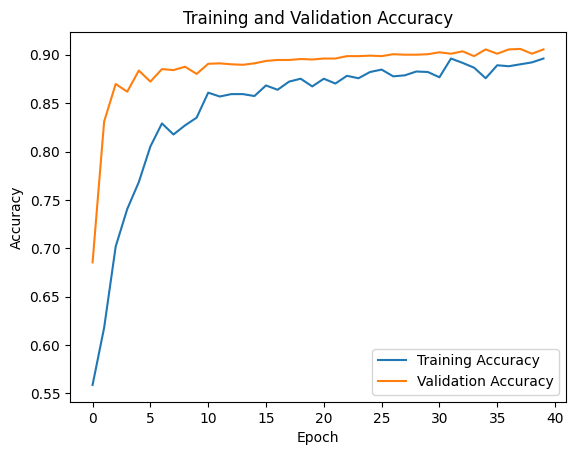

26/26 [==============================] - 186s 7s/step - loss: 0.2465 - accuracy: 0.9056
Validation Loss: 0.2464718371629715
Validation Accuracy: 0.9055665731430054


In [3]:
'''import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the directory containing your images
image_directory = 'resized_images/train/all'  # Replace with the actual directory path

# Load the CSV file with data in the form of {"cataract": "1"}
labeled_data = pd.read_csv('label_data.csv')  # Replace with the actual file path

# Assuming that the CSV file contains a 'filename' column with image file names
image_filenames = labeled_data['filename'].values

# Construct the complete image paths by joining the directory path and file names
image_paths = [os.path.join(image_directory, filename) for filename in image_filenames]

# Extract the labels from the JSON-formatted "region_attributes" column
labels = [int(json.loads(label_str)['cataract']) for label_str in labeled_data['disease']]

# Load the images and convert them to a NumPy array
normalized_images_array = np.load('normalized_images.npy')

# Load the VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Split your dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(normalized_images_array, labels, test_size=0.2, random_state=42)

# Convert the data to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
#e=10,b=100,a=71.34
#e=20,b=15, a=80.61
#e=23,b=12, a=80.85
#e=30,b=5, a=80.85
#e=50,b=5, a=84.63
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=5)

# Save the trained model for future use
model.save('cataract_detection_vgg19.h5')

pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title('Pre-Trained Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()'''


import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing your images
image_directory = 'resized_images/train/all'  # Replace with the actual directory path

# Load the CSV file with data in the form of {"cataract": "1"}
labeled_data = pd.read_csv('label_data.csv')  # Replace with the actual file path

# Define image data generators for training and validation with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    labeled_data,
    directory=image_directory,
    x_col='filename',
    y_col='disease',
    target_size=(224, 224),
    batch_size=80,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    labeled_data,
    directory=image_directory,
    x_col='filename',
    y_col='disease',
    target_size=(224, 224),
    batch_size=80,
    class_mode='binary',
    shuffle=False
)

# Load the VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#epochs 20 , 89.71

history = model.fit(train_generator, epochs=40, validation_data=val_generator, callbacks=[early_stopping])

#model.save('cataract_detection_vgg19_optimized.h5')

model.save('cataract_detection_vgg19_optimized_1.keras')
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate the model on the validation set
evaluation = model.evaluate(val_generator)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])